In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
from scipy.io import wavfile
import librosa
import librosa.display
import matplotlib.pyplot as plt
import json
import os
import numpy as np
import skimage.io
import cv2
import tensorflow as tf
import csv
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns

from google.colab.patches import cv2_imshow

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
class CoughDetector(tf.keras.Model):

  def __init__(self):
    super(CoughDetector, self).__init__()
    self.MaxPool1 = tf.keras.layers.MaxPool2D(pool_size=(2,2))
    self.Conv1 = tf.keras.layers.Conv2D(filters = 16,kernel_size=(5,5), activation=tf.nn.relu)
    self.Conv2 = tf.keras.layers.Conv2D(filters = 16,kernel_size=(5,5), activation=tf.nn.relu)
    self.MaxPool2 = tf.keras.layers.MaxPool2D(pool_size=(2,2))
    self.Dropout1 = tf.keras.layers.Dropout(rate = 0.15)
    self.Conv3 = tf.keras.layers.Conv2D(filters = 16,kernel_size=(5,5), activation=tf.nn.relu)
    self.Conv4 = tf.keras.layers.Conv2D(filters = 16,kernel_size=(5,5), activation=tf.nn.relu)
    self.MaxPool3 = tf.keras.layers.MaxPool2D(pool_size=(2,2))
    self.Dropout2 = tf.keras.layers.Dropout(rate = 0.15)
    self.flatten = tf.keras.layers.Flatten()
    self.Dense1 = tf.keras.layers.Dense(256)
    self.Dropout3 = tf.keras.layers.Dropout(rate = 0.30)
    self.Dense2 = tf.keras.layers.Dense(2,activation=tf.nn.softmax)

  def call(self, inputs):
    x = self.MaxPool1(inputs)
    x = self.Conv1(x)
    x = self.Conv2(x)
    x = self.MaxPool2(x)
    x = self.Dropout1(x)
    x = self.Conv3(x)
    x = self.Conv4(x)
    x = self.MaxPool3(x)
    x = self.Dropout2(x)
    x = self.flatten(x)
    x = self.Dense1(x)
    x = self.Dropout3(x)
    x = self.Dense2(x)
    return x

class DTLMC(tf.keras.Model):

  def __init__(self):
    super(DTLMC, self).__init__()
    self.MaxPool1 = tf.keras.layers.MaxPool2D(pool_size=(2,2))
    self.Conv1 = tf.keras.layers.Conv2D(filters = 16,kernel_size=(5,5), activation=tf.nn.relu)
    self.Conv2 = tf.keras.layers.Conv2D(filters = 16,kernel_size=(5,5), activation=tf.nn.relu)
    self.MaxPool2 = tf.keras.layers.MaxPool2D(pool_size=(2,2))
    self.Dropout1 = tf.keras.layers.Dropout(rate = 0.15)
    self.Conv3 = tf.keras.layers.Conv2D(filters = 16,kernel_size=(5,5), activation=tf.nn.relu)
    self.Conv4 = tf.keras.layers.Conv2D(filters = 16,kernel_size=(5,5), activation=tf.nn.relu)
    self.MaxPool3 = tf.keras.layers.MaxPool2D(pool_size=(2,2))
    self.Dropout2 = tf.keras.layers.Dropout(rate = 0.15)
    self.flatten = tf.keras.layers.Flatten()
    self.Dense1 = tf.keras.layers.Dense(256)
    self.Dropout3 = tf.keras.layers.Dropout(rate = 0.30)
    self.Dense2 = tf.keras.layers.Dense(3,activation=tf.nn.softmax)

  def call(self, inputs):
    x = self.MaxPool1(inputs)
    x = self.Conv1(x)
    x = self.Conv2(x)
    x = self.MaxPool2(x)
    x = self.Dropout1(x)
    x = self.Conv3(x)
    x = self.Conv4(x)
    x = self.MaxPool3(x)
    x = self.Dropout2(x)
    x = self.flatten(x)
    x = self.Dense1(x)
    x = self.Dropout3(x)
    x = self.Dense2(x)
    return x

class DTLBC(tf.keras.Model):

  def __init__(self):
    super(DTLBC, self).__init__()
    self.MaxPool1 = tf.keras.layers.MaxPool2D(pool_size=(2,2))
    self.Conv1 = tf.keras.layers.Conv2D(filters = 16,kernel_size=(5,5), activation=tf.nn.relu)
    self.Conv2 = tf.keras.layers.Conv2D(filters = 16,kernel_size=(5,5), activation=tf.nn.relu)
    self.MaxPool2 = tf.keras.layers.MaxPool2D(pool_size=(2,2))
    self.Dropout1 = tf.keras.layers.Dropout(rate = 0.15)
    self.Conv3 = tf.keras.layers.Conv2D(filters = 16,kernel_size=(5,5), activation=tf.nn.relu)
    self.Conv4 = tf.keras.layers.Conv2D(filters = 16,kernel_size=(5,5), activation=tf.nn.relu)
    self.MaxPool3 = tf.keras.layers.MaxPool2D(pool_size=(2,2))
    self.Dropout2 = tf.keras.layers.Dropout(rate = 0.15)
    self.flatten = tf.keras.layers.Flatten()
    self.Dense1 = tf.keras.layers.Dense(256)
    self.Dropout3 = tf.keras.layers.Dropout(rate = 0.30)
    self.Dense2 = tf.keras.layers.Dense(2,activation=tf.nn.softmax)

  def call(self, inputs):
    x = self.MaxPool1(inputs)
    x = self.Conv1(x)
    x = self.Conv2(x)
    x = self.MaxPool2(x)
    x = self.Dropout1(x)
    x = self.Conv3(x)
    x = self.Conv4(x)
    x = self.MaxPool3(x)
    x = self.Dropout2(x)
    x = self.flatten(x)
    x = self.Dense1(x)
    x = self.Dropout3(x)
    x = self.Dense2(x)
    return x

class SVM():

  def __init__(self):
    self.clf = sklearn.svm.SVC(kernel='linear')
    # other possible kernels include: "linear", "polynomial", "rbf", "sigmoid"

  def fit(X, y):
    self.clf.fit(X,y)

  def predict(X):
    return self.clf.predict(X)

In [ ]:
def generateMfcc(filename, path='./drive/MyDrive/COUGHVID/test_dset/'):
  x, sr = load_soundfile_from_drive(filename,path)
  mfcc = librosa.feature.mfcc(y=x, sr=sr, n_mfcc=128)

  return mfcc

def extractFeaturesFromMfcc(mfcc, P):
  #P describes over how many principal components we sum over
  means = np.mean(mfcc,axis=1)
  pca = PCA(n_components = P)
  pca.fit_transform(mfcc.T)
  pcaProjections = pca.components_.T
  pcaMagnitudes = np.sum(np.abs(pcaProjections),axis=1)
  
  return np.concatenate((means, pcaMagnitudes))

In [ ]:
feature1

NameError: ignored

With the library 'librosa', we can easily handle audio files and create data arrays and spectograms out of the cough samples:

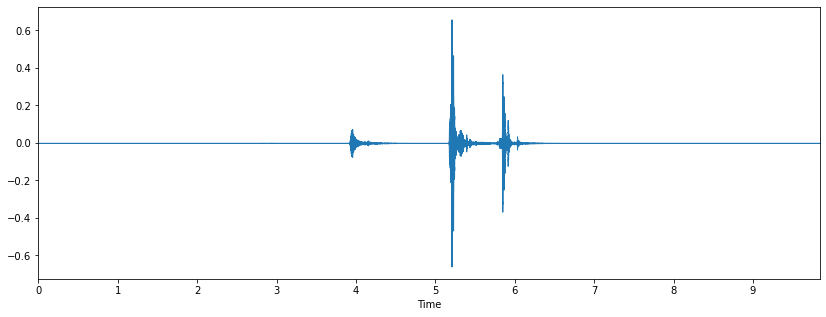

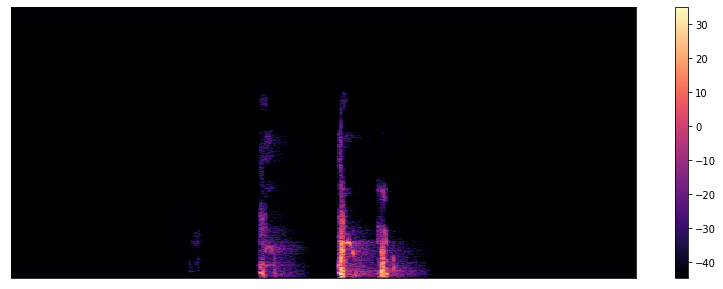

In [ ]:
x , sr = librosa.load('./drive/MyDrive/COUGHVID/testcough.webm')
plt.figure(figsize=(14,5))
librosa.display.waveplot(x)
x_new = librosa.stft(x)
x_db = librosa.amplitude_to_db(abs(x_new))

plt.figure(figsize=(14,5))
librosa.display.specshow(x_db, sr=sr)
plt.colorbar()

We create some helper functions to handle file extractions and spectogram image creation:

In [2]:

def load_json_from_drive(filename):
  with open('./drive/MyDrive/COUGHVID/' + filename) as json_file:
    data = json.load(json_file)
  
  return data

def load_soundfile_from_drive(filename, path='./drive/MyDrive/COUGHVID/test_dset/'):
  x , sr = librosa.load(path + filename)
  return x, sr

def jsonFileNames(path='./drive/MyDrive/COUGHVID/test_dset/'):
    """
    Returns the names of all .json files in the path as list of strings
    """
    jsonFileNames = []
    for (dirpath, dirnames, filenames) in os.walk(path):
      for filename in filenames:
        if ".json" in filename:
          jsonFileNames.append(filename)
    return jsonFileNames

def hasStatusAttribute(fileName, path='./drive/MyDrive/COUGHVID/test_dset/'):
    """
    Returns a boolean indicating if the specified json file has a 'status' key    
    """
    with open(os.path.join(path,fileName)) as file:
        data = json.load(file)
        hasStatusAttribute = 'status' in data
        #print('statusAttribute: ' + str(hasStatusAttribute))
        return hasStatusAttribute

def valueFromJsonParser(fileName, key, path='./drive/MyDrive/COUGHVID/test_dset/'):
    """
    Returns the status of the specified json file 
    """    
    with open(os.path.join(path, fileName)) as file:
        data = json.load(file)
        return data[str(key)]

def generateMelSpectrogram(fileName, inputPath='./drive/MyDrive/COUGHVID/test_dset/'):
    """
    Generates Mel Spectogram from cough sample.
    Note: multiply values by -1 to avoid black images during png conversion
    """
    x, sr = load_soundfile_from_drive(fileName, inputPath)
    M = librosa.feature.melspectrogram(y=x, sr=sr, n_mels=128)
    M_db = librosa.power_to_db(M, ref=np.max) * -1
    dim = (320,240) # resize to dimensions from https://www.sciencedirect.com/science/article/pii/S2352914820303026
    resized = cv2.resize(M_db, dim, interpolation=cv2.INTER_LINEAR)

    return resized

def coughDetectionIsAboveThreshold(fileName, threshold, path='./drive/MyDrive/COUGHVID/test_dset/'):
    coughDetectionIsAboveThreshold = False
    if float(valueFromJsonParser(fileName,'cough_detected',path)) > threshold:
        coughDetectionIsAboveThreshold = True
    return coughDetectionIsAboveThreshold

def generateAllMelSpectrogramsAndLabelsFile(outputPath, threshold, nData, inputPath='./drive/MyDrive/COUGHVID/test_dset/'):
    LabelsList = []
    ThresholdList = []
    filenames = jsonFileNamesTest()
    if nData > 0:
      filenames = filenames[0:nData - 1]
    for filename in filenames:
      filename = filename.strip()
      try:
        if hasStatusAttribute(filename,inputPath) and coughDetectionIsAboveThreshold(filename, threshold, inputPath):
          LabelsList.append(valueFromJsonParser(filename,'status',inputPath))
          ThresholdList.append(valueFromJsonParser(filename,'cough_detected',inputPath))
          audioFileName = filename.strip(".json")+".webm"
          if os.path.isfile(inputPath + audioFileName) == False:
            audioFileName = filename.strip(".json")+".ogg"
          melSpectrogram = generateMelSpectrogramTest(audioFileName,inputPath)
          melSpectrogramFileName = filename.strip(".json")+".png"
          melSpectrogramFilePath = os.path.join(outputPath,melSpectrogramFileName)
          cv2.imwrite(melSpectrogramFilePath, melSpectrogram)
      except FileNotFoundError:
        print('File was not found')
        continue
    with open(os.path.join(outputPath,"LabelsAndThresholds.csv"), 'w') as file:
      wr = csv.writer(file)
      wr.writerow(LabelsList)
      wr.writerow(ThresholdList)

    
def readAllMelSpecs(path='./drive/MyDrive/COUGHVID/test_dset/'):
  data = []
  for (dirpath, dirnames, filenames) in os.walk(path):
    for file in filenames:
      if '.png' in file:
        filepath = path + file
        tmp = cv2.imread(filepath, cv2.IMREAD_UNCHANGED)
        tmp_expanded=np.expand_dims(tmp,axis=2)
        data.append(tmp_expanded)

  return np.float32(np.array(data))

def oneHotEncoding(labels):
  oneHotList = []
  for label in labels:
    if label == 'healthy':
      oneHotList.append([1,0,0])
    elif label == 'symptomatic':
      oneHotList.append([0,1,0])
    elif label == 'COVID-19':
      oneHotList.append([0,0,1])

  return np.array(oneHotList)

def convertCSVToArrays(filepath = './drive/MyDrive/COUGHVID/test_dset/MelDiagrams/LabelsAndThresholds.csv'):

  labels = []
  coughValues = []

  with open(filepath, newline='') as csvfile:
      spamreader = csv.reader(csvfile, delimiter=' ', quotechar='|')
      for index, row in enumerate(spamreader):
          entries = row[0].split(',')
          if index == 0:
            labels = entries
          else:
            coughValues = entries
  
  return np.array(labels), np.array(coughValues)

In [ ]:
generateAllMelSpectrogramsAndLabelsFile('./drive/MyDrive/COUGHVID/test_dset/MelDiagrams', 0.0)


In [ ]:
labels, _ = convertCSVToArrays()

X = readAllMelSpecs()
Y = oneHotEncoding(labels)


print(X.shape)
print(Y.shape)

(25, 240, 320, 1)
(25, 3)


--------- preprocessing done ------------

In [ ]:
# lets keep this, maybe we will need this
def transform_function(frequency):
  return 2595 * np.log10(1 + (frequency/700))

  

In [ ]:
model = DTLMC()

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.BinaryCrossentropy())

In [ ]:
model.fit(X,Y)

1/1 [==============================] - 2s 2s/step - loss: 1.5942


In [ ]:
x_single = np.expand_dims(X[0],axis=0)
y_single = np.expand_dims(Y[0],axis=0)

output = model.call(x_single)

In [ ]:
def jsonFileNamesTest():
    """
    Returns the names of all .json files in the path as list of strings
    """
    tmp = !ls './drive/MyDrive/COUGHVID/public_dataset/'
    filenames = np.array(tmp)
    jsonFileNames = []
    for filename in filenames:
      if ".json" in filename:
        jsonFileNames.append(filename)
    return jsonFileNames

def generateMelSpectrogramTest(fileName, inputPath='./drive/MyDrive/COUGHVID/public_dataset/'):
    """
    Generates Mel Spectogram from cough sample.
    Note: multiply values by -1 to avoid black images during png conversion
    """
    x, sr = load_soundfile_from_drive(fileName,inputPath)
    M = librosa.feature.melspectrogram(y=x, sr=sr, n_mels=128)
    M_db = librosa.power_to_db(M, ref=np.max) * -1
    dim = (320,240) # resize to dimensions from https://www.sciencedirect.com/science/article/pii/S2352914820303026
    resized = cv2.resize(M_db, dim, interpolation=cv2.INTER_LINEAR)

    return resized


def generateAllMelSpectrogramsAndLabelsFileTraining(outputPath, threshold, inputPath='./drive/MyDrive/COUGHVID/public_dataset/'):
    LabelsList = []
    ThresholdList = []
    filenames = jsonFileNamesTest()
    filenames = filenames[0:1200]
    for filename in filenames:
      filename = filename.strip()
      try:
        if hasStatusAttribute(filename,inputPath) and coughDetectionIsAboveThreshold(filename, threshold, inputPath):
          LabelsList.append(valueFromJsonParser(filename,'status',inputPath))
          ThresholdList.append(valueFromJsonParser(filename,'cough_detected',inputPath))
          audioFileName = filename.strip(".json")+".webm"
          if os.path.isfile(inputPath + audioFileName) == False:
            audioFileName = filename.strip(".json")+".ogg"
          melSpectrogram = generateMelSpectrogramTest(audioFileName,inputPath)
          melSpectrogramFileName = filename.strip(".json")+".png"
          melSpectrogramFilePath = os.path.join(outputPath,melSpectrogramFileName)
          cv2.imwrite(melSpectrogramFilePath, melSpectrogram)
          #print('file written:' + melSpectrogramFilePath)
      except FileNotFoundError:
        print('File was not found')
        continue
    with open(os.path.join(outputPath,"LabelsAndThresholds.csv"), 'w') as file:
      wr = csv.writer(file)
      wr.writerow(LabelsList)
      wr.writerow(ThresholdList)

def readAllMelSpecsTest():
  data = []
  for (dirpath, dirnames, filenames) in os.walk('./drive/MyDrive/COUGHVID/large_test_dset/'):
    for file in filenames:
      if '.png' in file:
        filepath = './drive/MyDrive/COUGHVID/large_test_dset/' + file
        tmp = cv2.imread(filepath, cv2.IMREAD_UNCHANGED)
        tmp_expanded=np.expand_dims(tmp,axis=2)
        data.append(tmp_expanded)

  return np.float32(np.array(data))

In [ ]:
generateAllMelSpectrogramsAndLabelsFileTraining('./drive/MyDrive/COUGHVID/large_test_dset/', 0.0)


In [ ]:
data_large = readAllMelSpecsTest()
labels_large, _ = convertCSVToArrays('./drive/MyDrive/COUGHVID/large_test_dset/LabelsAndThresholds.csv')

In [ ]:
print(labels_large.shape)
print(data_large.shape)
tmp = (data_large[0].reshape((1,240*320)) == 80.)
#print(data_large[0])
print(len(np.nonzero(tmp)))
#cv2_imshow(data_large[0])

(699,)
(699, 240, 320, 1)
2


8----------------DONT TOUCH ANYTHING ABOVE THIS LINE ------------------------------------------------- D

In [ ]:
#First attempt with SVM to train

##Data preparation
generateAllMelSpectrogramsAndLabelsFile('./drive/MyDrive/COUGHVID/test_dset/MelSpecs',
                                        0.0,
                                        './drive/MyDrive/COUGHVID/test_dset')

In [ ]:
tmp = !ls './drive/MyDrive/COUGHVID/test_dset'

In [ ]:
jsonFileNames('./drive/MyDrive/COUGHVID/test_dset')

In [ ]:
filenames = []

for path, dirs, files in os.walk('./drive/MyDrive/COUGHVID/test_dset'):
  filenames.append(files)

In [ ]:
#print(filenames)
print(X.shape)

(200, 76800)


In [ ]:
X = np.reshape(data_large[:,:,:,0], (data_large.shape[0], 240*320))
pca = PCA(n_components = 100)
pca.fit_transform(X)
pcaProjections = pca.components_.T
y = labels_large

tsne = TSNE(n_components=2)
tsne_result = tsne.fit_transform(X)
print(tsne_result.shape)

(699, 2)


Plotting (the plott sucks because somehow the function "readAllMelSpecsTest" doesnt read the png's correctly - it reads or writes 80 everywhere)

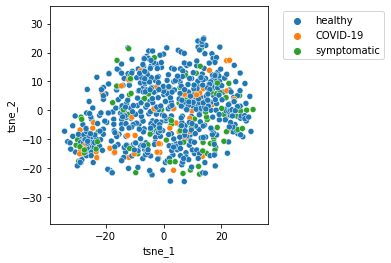

In [ ]:
tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': y})
fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax)
lim = (tsne_result.min()-5, tsne_result.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2)

In [ ]:
soundFileNames = []
for (dirpath, dirnames, filenames) in os.walk('./drive/MyDrive/COUGHVID/public_dataset/'):
  for filename in filenames:
    if ".webm" in filename or ".ogg" in filename:
      soundFileNames.append(filename)



TypeError: ignored

In [ ]:
tmp = generateMfcc(soundFileNames[3], './drive/MyDrive/COUGHVID/public_dataset/')
#print(tmp)
print(extractFeaturesFromMfcc(tmp,P = 10).shape)

(256,)


In [ ]:
data = np.zeros(shape=(256,))
for filename in soundFileNames[0:10]:
  mfcc = generateMfcc(filename, './drive/MyDrive/COUGHVID/public_dataset/')
  features = extractFeaturesFromMfcc(mfcc, P = 10)
  data = np.vstack((data, features))

In [ ]:
data.shape

(11, 256)